In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

#load files
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])
id_test = test.id

In [2]:
print(train.shape)
print(test.shape)

(30471, 292)
(7662, 291)


In [3]:
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN

In [4]:
train.product_type.value_counts(normalize= True)

Investment       0.638246
OwnerOccupier    0.361754
Name: product_type, dtype: float64

In [5]:
test.product_type.value_counts(normalize= True)

Investment       0.655132
OwnerOccupier    0.344868
Name: product_type, dtype: float64

In [6]:
train.ix[3000:3010,'product_type']

3000       Investment
3001       Investment
3002       Investment
3003       Investment
3004    OwnerOccupier
3005       Investment
3006       Investment
3007       Investment
3008       Investment
3009       Investment
3010       Investment
Name: product_type, dtype: object

In [7]:
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN

In [8]:
train.floor.describe(percentiles= [0.9999])

count     30295.000000
mean          7.673081
std           5.319135
min           1.000000
50%           7.000000
99.99%       40.911800
max          77.000000
Name: floor, dtype: float64

In [9]:
train['floor'].argmax()

23584

In [10]:
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN

In [11]:
train.material.value_counts()

1.0    14197
2.0     2993
5.0     1561
4.0     1344
6.0      803
3.0        1
Name: material, dtype: int64

In [12]:
test.material.value_counts()

1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64

In [13]:
train.state.value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

In [14]:
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()

2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [15]:
bad_index = train[train.full_sq == 0].index

In [16]:
bad_index.shape

(0,)

In [17]:
train = train[train.price_doc/train.full_sq <= 600000]

In [18]:
train.shape

(30431, 292)

In [19]:
train = train[train.price_doc/train.full_sq >= 10000]
train.shape

(30396, 292)

In [20]:
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)

In [21]:
type(month_year)

pandas.core.series.Series

In [22]:
month_year[0:10]

0    201108
1    201108
2    201108
3    201109
4    201109
5    201109
6    201109
7    201109
8    201109
9    201109
Name: timestamp, dtype: int64

In [23]:
month_year_cnt_map = month_year.value_counts().to_dict()

In [24]:
type(month_year_cnt_map)

dict

In [25]:
month_year_cnt_map

{201108: 3,
 201109: 39,
 201110: 211,
 201111: 257,
 201112: 238,
 201201: 254,
 201202: 359,
 201203: 374,
 201204: 298,
 201205: 294,
 201206: 356,
 201207: 389,
 201208: 335,
 201209: 544,
 201210: 509,
 201211: 548,
 201212: 551,
 201301: 263,
 201302: 275,
 201303: 772,
 201304: 838,
 201305: 532,
 201306: 520,
 201307: 756,
 201308: 661,
 201309: 643,
 201310: 891,
 201311: 915,
 201312: 904,
 201401: 867,
 201402: 1143,
 201403: 1200,
 201404: 1293,
 201405: 1123,
 201406: 1276,
 201407: 727,
 201408: 831,
 201409: 1112,
 201410: 1118,
 201411: 1243,
 201412: 1697,
 201501: 420,
 201502: 490,
 201503: 617,
 201504: 755,
 201505: 542,
 201506: 413}

In [26]:
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [27]:
train.ix[0:10,'month_year_cnt']

0      3
1      3
2      3
3     39
4     39
5     39
6     39
7     39
8     39
9     39
10    39
Name: month_year_cnt, dtype: int64

In [28]:
month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [29]:
# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

In [30]:
# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

In [31]:
train.ix[1:15,'metro_km_avto']

1     0.647337
2     1.637996
3     0.984537
4     0.876620
5     1.593246
6     1.026916
7     1.593203
8     1.338707
9     0.396275
10    1.278159
11    2.067243
12    1.623329
13    1.214706
14    0.590130
15    1.045237
Name: metro_km_avto, dtype: float64

In [32]:
train.ix[1:15,'sub_area']

1     Nagatinskij Zaton
2        Tekstil'shhiki
3                Mitino
4             Basmannoe
5        Nizhegorodskoe
6            Sokol'niki
7              Bibirevo
8               Koptevo
9               Kuncevo
10     Kosino-Uhtomskoe
11    Zapadnoe Degunino
12              Kuncevo
13          Presnenskoe
14            Lefortovo
15              Mar'ino
Name: sub_area, dtype: object

In [33]:
train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)


In [34]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

In [35]:
num_train = len(x_train)
num_train

30396

In [36]:
x_all = pd.concat([x_train, x_test])
x_all

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,leisure_count_5000,sport_count_5000,market_count_5000,month_year_cnt,week_year_cnt,month,dow,rel_floor,rel_kitch_sq,room_size
0,43.00,27.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,0,52,4,3,1,8,5,NaN,NaN,NaN
1,34.00,19.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,10,66,14,3,2,8,1,NaN,NaN,NaN
2,43.00,29.00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,4,67,10,3,2,8,5,NaN,NaN,NaN
3,89.00,50.00,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,0,26,3,39,1,9,3,NaN,NaN,NaN
4,77.00,77.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,91,195,14,39,5,9,0,NaN,NaN,NaN
5,67.00,46.00,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,20,113,17,39,5,9,1,NaN,NaN,NaN
6,25.00,14.00,10.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,27,127,8,39,5,9,3,NaN,NaN,NaN
7,44.00,44.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,0,47,4,39,5,9,4,NaN,NaN,NaN
8,42.00,27.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,3,85,11,39,5,9,5,NaN,NaN,NaN
9,36.00,21.00,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,3,67,1,39,4,9,1,NaN,NaN,NaN


In [37]:
#將object類型的data轉為int
# for f in test_df.columns:
#     if test_df[f].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(test_df[f].values)) 
#         test_df[f] = lbl.transform(list(test_df[f].values))

for c in x_all.columns:
    if x_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_all[c].values)) 
        x_all[c] = lbl.transform(list(x_all[c].values))

In [38]:
x_train = x_all[:num_train]
x_test = x_all[num_train:]

In [45]:
xgb_params = {
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [46]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.33312e+06	test-rmse:8.33692e+06
[50]	train-rmse:3.11601e+06	test-rmse:3.32713e+06
[100]	train-rmse:2.32097e+06	test-rmse:2.69856e+06
[150]	train-rmse:2.14972e+06	test-rmse:2.60731e+06
[200]	train-rmse:2.06273e+06	test-rmse:2.57297e+06
[250]	train-rmse:1.997e+06	test-rmse:2.54941e+06
[300]	train-rmse:1.94388e+06	test-rmse:2.53347e+06
[350]	train-rmse:1.89548e+06	test-rmse:2.52252e+06
[400]	train-rmse:1.85392e+06	test-rmse:2.51287e+06
[450]	train-rmse:1.81426e+06	test-rmse:2.5062e+06
[500]	train-rmse:1.77707e+06	test-rmse:2.49934e+06
[550]	train-rmse:1.7437e+06	test-rmse:2.49525e+06
[600]	train-rmse:1.71332e+06	test-rmse:2.4938e+06
[650]	train-rmse:1.68363e+06	test-rmse:2.49157e+06
[700]	train-rmse:1.65399e+06	test-rmse:2.48959e+06
[750]	train-rmse:1.62671e+06	test-rmse:2.48765e+06


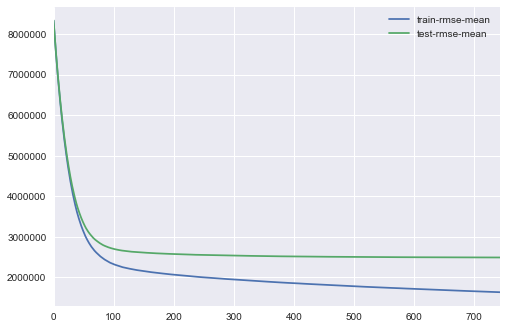

In [47]:
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [48]:
num_boost_rounds = len(cv_output)
num_boost_rounds

744

In [49]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=700)

In [50]:
y_predict = model.predict(dtest)

In [51]:
gunja_output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
gunja_output.head()

,id,price_doc
0,30474,5412617.0
1,30475,8022903.5
2,30476,5272272.5
3,30477,5876963.0
4,30478,5002661.5


In [53]:
gunja_output.to_csv('clean_1.csv', index=False)

## rate 0.005

In [39]:
def modelfit(alg, X_train, Y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, Y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='rmse',verbose_eval=50, show_stdv=False, early_stopping_rounds=early_stopping_rounds)
        #alg.set_params(n_estimators=cvresult.shape[0])
        global num_boost_rounds
        num_boost_rounds = len(cvresult)
        print(num_boost_rounds)
        cvresult[['train-rmse-mean', 'test-rmse-mean']].plot()
        plt.show()

[0]	train-rmse:8.52003e+06	test-rmse:8.5203e+06
[50]	train-rmse:6.87973e+06	test-rmse:6.91932e+06
[100]	train-rmse:5.62011e+06	test-rmse:5.70422e+06
[150]	train-rmse:4.66102e+06	test-rmse:4.7982e+06
[200]	train-rmse:3.93667e+06	test-rmse:4.13138e+06
[250]	train-rmse:3.39619e+06	test-rmse:3.65125e+06
[300]	train-rmse:2.99558e+06	test-rmse:3.31125e+06
[350]	train-rmse:2.70198e+06	test-rmse:3.074e+06
[400]	train-rmse:2.48629e+06	test-rmse:2.90943e+06
[450]	train-rmse:2.33001e+06	test-rmse:2.79733e+06
[500]	train-rmse:2.21357e+06	test-rmse:2.72046e+06
[550]	train-rmse:2.12602e+06	test-rmse:2.66711e+06
[600]	train-rmse:2.05982e+06	test-rmse:2.62892e+06
[650]	train-rmse:2.00834e+06	test-rmse:2.60243e+06
[700]	train-rmse:1.96802e+06	test-rmse:2.58298e+06
[750]	train-rmse:1.93459e+06	test-rmse:2.56729e+06
[800]	train-rmse:1.9051e+06	test-rmse:2.55572e+06
[850]	train-rmse:1.87951e+06	test-rmse:2.5453e+06
[900]	train-rmse:1.8569e+06	test-rmse:2.53787e+06
[950]	train-rmse:1.83638e+06	test-rmse:2.

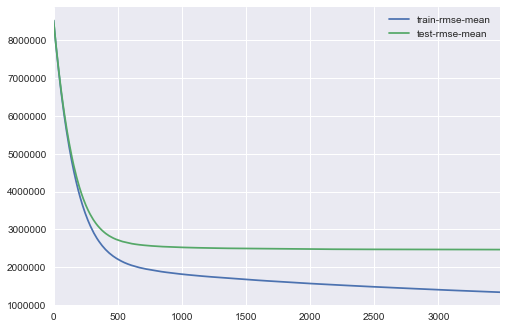

In [40]:
from xgboost.sklearn import XGBRegressor
xgb2 = XGBRegressor(
 learning_rate =0.005,
 n_estimators=10000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=100,
 reg_lambda=1,
 seed=27)
modelfit(xgb2, x_train, y_train)

In [41]:
num_boost_rounds

3481

In [43]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

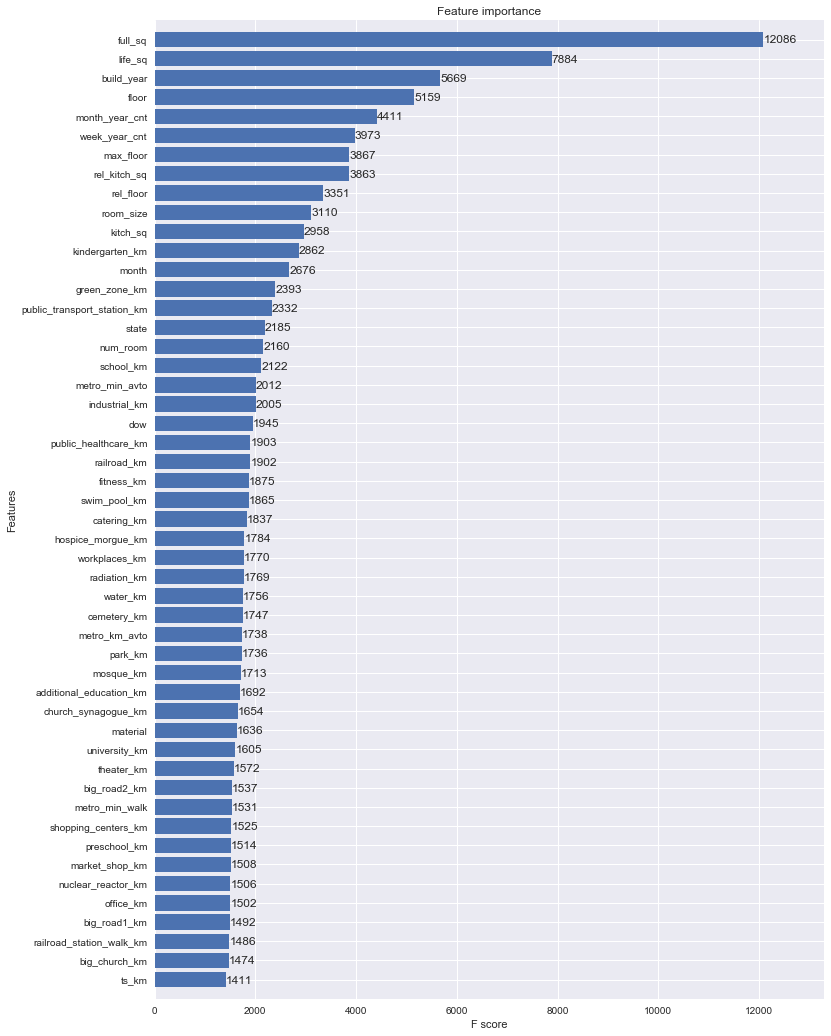

In [44]:
model = xgb.train(xgb2.get_xgb_params(), dtrain, num_boost_round= num_boost_rounds)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [45]:
y_predict = model.predict(dtest)

In [46]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5557961.5
1,30475,8085242.5
2,30476,5495616.0
3,30477,6044013.5
4,30478,4813428.0


In [47]:
output.to_csv('clean_2_0.005.csv', index=False)